# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

[Te proporcionamos algunos comentarios para orientarte mientras completas este proyecto. Pero debes asegurarte de eliminar todos los comentarios entre corchetes antes de entregar tu proyecto.]

[Antes de sumergirte en el análisis de datos, explica por tu propia cuenta el propósito del proyecto y las acciones que planeas realizar.]

[Ten en cuenta que estudiar, modificar y analizar datos es un proceso iterativo. Es normal volver a los pasos anteriores y corregirlos/ampliarlos para permitir nuevos pasos.]

## Inicialización

In [30]:
# Cargar todas las librerías
import numpy as np
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()


## Cargar datos

In [31]:
# Carga los archivos de datos en diferentes DataFrames
calls = pd.read_csv("megaline_calls.csv")
internet = pd.read_csv("megaline_internet.csv")
messages = pd.read_csv("megaline_messages.csv")
plans = pd.read_csv("megaline_plans.csv")
users = pd.read_csv("megaline_users.csv")


In [32]:
def looks(datos):
    print("describe:")
    print(datos.describe(include= "all"))
    print()
    print("info:")
    print(datos.info())
    print()
    print("Head:")
    print(datos.head())
    print()
    print("NA?:")
    print(datos.isna().sum())
    print()
    print("Duplicados:")
    print(datos.duplicated().sum())

## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

### Tarifas

In [33]:
# Imprime una muestra de los datos para las tarifas
looks(plans)


describe:
        messages_included  mb_per_month_included  minutes_included  \
count            2.000000               2.000000          2.000000   
unique                NaN                    NaN               NaN   
top                   NaN                    NaN               NaN   
freq                  NaN                    NaN               NaN   
mean           525.000000           23040.000000       1750.000000   
std            671.751442           10861.160159       1767.766953   
min             50.000000           15360.000000        500.000000   
25%            287.500000           19200.000000       1125.000000   
50%            525.000000           23040.000000       1750.000000   
75%            762.500000           26880.000000       2375.000000   
max           1000.000000           30720.000000       3000.000000   

        usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
count          2.000000     2.00000         2.000000        2.000000

[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

#### Corregir datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

 No existen datos que haya que corregir ya que son solo dos tarifas y los datos de los mismos

#### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [34]:
plans["gb_per_month"] =  plans["mb_per_month_included"]/1024
#se añade una columa con los GB por mes, para hacer mas manejables los datos y faciles de entender

## Usuarios/as

In [35]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
looks(users)


describe:
            user_id first_name last_name         age  \
count    500.000000        500       500  500.000000   
unique          NaN        458       399         NaN   
top             NaN    Leonila     David         NaN   
freq            NaN          3         3         NaN   
mean    1249.500000        NaN       NaN   45.486000   
std      144.481833        NaN       NaN   16.972269   
min     1000.000000        NaN       NaN   18.000000   
25%     1124.750000        NaN       NaN   30.000000   
50%     1249.500000        NaN       NaN   46.000000   
75%     1374.250000        NaN       NaN   61.000000   
max     1499.000000        NaN       NaN   75.000000   

                                             city    reg_date  plan  \
count                                         500         500   500   
unique                                         73         266     2   
top     New York-Newark-Jersey City, NY-NJ-PA MSA  2018-03-08  surf   
freq                             

[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

 Se observa que solo 34 usuarios cancelaron su plan, como indican los ausentes en _churn_date_. Ademas se observa que la columna reg_date es un string, se decide dejarlo asi de momento a menos que se requieran operaciones que deban tener en cuenta el tiempo. 

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [36]:
users["reg_date"] = pd.to_datetime(users["reg_date"])
users["churn_date"] = pd.to_datetime(users["churn_date"])


In [37]:
users["city"].value_counts()

city
New York-Newark-Jersey City, NY-NJ-PA MSA          80
Los Angeles-Long Beach-Anaheim, CA MSA             29
Dallas-Fort Worth-Arlington, TX MSA                21
Chicago-Naperville-Elgin, IL-IN-WI MSA             19
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA    17
                                                   ..
Raleigh-Cary, NC MSA                                1
El Paso, TX MSA                                     1
Greensboro-High Point, NC MSA                       1
Stockton, CA MSA                                    1
Cape Coral-Fort Myers, FL MSA                       1
Name: count, Length: 73, dtype: int64

In [38]:
users[~users["city"].str.contains("NY-NJ")]["city"].value_counts().sum()

420

## Llamadas

In [39]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
looks(calls)

describe:
             id        user_id   call_date       duration
count    137735  137735.000000      137735  137735.000000
unique   137735            NaN         351            NaN
top     1000_93            NaN  2018-12-27            NaN
freq          1            NaN        1091            NaN
mean        NaN    1247.658046         NaN       6.745927
std         NaN     139.416268         NaN       5.839241
min         NaN    1000.000000         NaN       0.000000
25%         NaN    1128.000000         NaN       1.290000
50%         NaN    1247.000000         NaN       5.980000
75%         NaN    1365.000000         NaN      10.690000
max         NaN    1499.000000         NaN      37.600000

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_dat

In [40]:
def redondeo(dur):
    red = np.ceil(dur)
    return int(red)

[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [41]:
calls["call_date"] = pd.to_datetime(calls["call_date"], format= "%Y-%m-%d")
calls["month"] = calls["call_date"].dt.month

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [42]:
calls["duracion_redond"] = calls["duration"].apply(redondeo)


## Mensajes

In [43]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
looks(messages)


describe:
              id       user_id message_date
count      76051  76051.000000        76051
unique     76051           NaN          351
top     1000_125           NaN   2018-12-28
freq           1           NaN          702
mean         NaN   1245.972768          NaN
std          NaN    139.843635          NaN
min          NaN   1000.000000          NaN
25%          NaN   1123.000000          NaN
50%          NaN   1251.000000          NaN
75%          NaN   1362.000000          NaN
max          NaN   1497.000000          NaN

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

Head:
         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000

[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [44]:
messages["message_date"] = pd.to_datetime(messages["message_date"])
messages["month"] = messages["message_date"].dt.month

## Internet

In [45]:
# Imprime la información general/resumida sobre el DataFrame de internet
looks(internet)


describe:
             id        user_id session_date        mb_used
count    104825  104825.000000       104825  104825.000000
unique   104825            NaN          351            NaN
top     1000_13            NaN   2018-12-24            NaN
freq          1            NaN          851            NaN
mean        NaN    1242.496361          NaN     366.713701
std         NaN     142.053913          NaN     277.170542
min         NaN    1000.000000          NaN       0.000000
25%         NaN    1122.000000          NaN     136.080000
50%         NaN    1236.000000          NaN     343.980000
75%         NaN    1367.000000          NaN     554.610000
max         NaN    1499.000000          NaN    1693.470000

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-nul

[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [46]:
internet["session_date"] = pd.to_datetime(internet["session_date"])
internet["gb_used"] = np.ceil(internet["mb_used"]/1024)
internet["month"] = internet["session_date"].dt.month
internet

,id,user_id,session_date,mb_used,gb_used,month
0,1000_13,1000,2018-12-29,89.86,1.0,12
1,1000_204,1000,2018-12-31,0.00,0.0,12
2,1000_379,1000,2018-12-28,660.40,1.0,12
3,1000_413,1000,2018-12-26,270.99,1.0,12
4,1000_442,1000,2018-12-27,880.22,1.0,12
...,...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,1.0,10
104821,1499_216,1499,2018-12-30,304.72,1.0,12
104822,1499_217,1499,2018-09-22,292.75,1.0,9
104823,1499_218,1499,2018-12-07,0.00,0.0,12


## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [47]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
plans


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [48]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
cals_per_user = calls.pivot_table(index= ["user_id","month"],values= "duracion_redond", aggfunc= ["sum", "count" ])
cals_per_user.columns = ["minutos_consumidos", "total_llamadas"]
cals_per_user.reset_index(inplace=True)


In [49]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
cals_per_user


,user_id,month,minutos_consumidos,total_llamadas
0,1000,12,124,16
1,1001,8,182,27
2,1001,9,315,49
3,1001,10,393,65
4,1001,11,426,64
...,...,...,...,...
2253,1498,12,339,39
2254,1499,9,346,41
2255,1499,10,385,53
2256,1499,11,308,45


In [50]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
msj_mth = messages.pivot_table(index= ["user_id","month"], values= "id", aggfunc= "count" ) #groupby(["user_id","month"])["id"].count()
msj_mth.columns = ["mensajes_enviados"]
msj_mth.reset_index(inplace=True)
msj_mth


,user_id,month,mensajes_enviados
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [51]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
#ith_mth = internet.groupby(["user_id","month"])["gb_used"].sum()
#ith_mth.reset_index(inplace=True)
ith_mth = internet.pivot_table(index=["user_id","month"], values= "gb_used", aggfunc= "sum")
ith_mth.columns = ["gb_consumidos"]
ith_mth.reset_index(inplace=True)
ith_mth

,user_id,month,gb_consumidos
0,1000,12,4.0
1,1001,8,21.0
2,1001,9,41.0
3,1001,10,50.0
4,1001,11,49.0
...,...,...,...
2272,1498,12,56.0
2273,1499,9,37.0
2274,1499,10,52.0
2275,1499,11,43.0


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [52]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
mth_cons = cals_per_user.merge(msj_mth, on= ["user_id","month"], how= "outer").merge(ith_mth, on= ["user_id","month"], how= "outer")

mth_cons[mth_cons["month"].isna()]


,user_id,month,minutos_consumidos,total_llamadas,mensajes_enviados,gb_consumidos


In [53]:
# Añade la información de la tarifa
usr_mth_cons= users[["plan","user_id","city"]].merge(mth_cons, on= "user_id", how= "inner") #Al hacer un inner se excluyen usuarios que no usaron el servico, se detectaron 10
bigtable = usr_mth_cons.merge(plans,left_on="plan", right_on= "plan_name")
bigtable.isna().sum()
bigtable.fillna(0, inplace=True)
bigtable

,plan,user_id,city,month,minutos_consumidos,total_llamadas,mensajes_enviados,gb_consumidos,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month
0,ultimate,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",12,124.0,16.0,11.0,4.0,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0
1,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",8,182.0,27.0,30.0,21.0,50,15360,500,20,10,0.03,0.03,surf,15.0
2,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",9,315.0,49.0,44.0,41.0,50,15360,500,20,10,0.03,0.03,surf,15.0
3,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",10,393.0,65.0,53.0,50.0,50,15360,500,20,10,0.03,0.03,surf,15.0
4,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",11,426.0,64.0,36.0,49.0,50,15360,500,20,10,0.03,0.03,surf,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,surf,1498,"New York-Newark-Jersey City, NY-NJ-PA MSA",12,339.0,39.0,0.0,56.0,50,15360,500,20,10,0.03,0.03,surf,15.0
2289,surf,1499,"Orlando-Kissimmee-Sanford, FL MSA",9,346.0,41.0,0.0,37.0,50,15360,500,20,10,0.03,0.03,surf,15.0
2290,surf,1499,"Orlando-Kissimmee-Sanford, FL MSA",10,385.0,53.0,0.0,52.0,50,15360,500,20,10,0.03,0.03,surf,15.0
2291,surf,1499,"Orlando-Kissimmee-Sanford, FL MSA",11,308.0,45.0,0.0,43.0,50,15360,500,20,10,0.03,0.03,surf,15.0


[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [54]:
# Calcula el ingreso mensual para cada usuario
def cobro_llamadas (fila):
    minutos_cons = fila["minutos_consumidos"]
    consumo_excedente = 0

    
    if minutos_cons > fila["minutes_included"]:
        consumo_excedente=(minutos_cons - fila["minutes_included"])*fila["usd_per_minute"]
    

    return consumo_excedente

def cobro_msj(fila):
    cons = fila["mensajes_enviados"]
    consumo_excedente = 0
    
    if cons > fila["messages_included"]:
        consumo_excedente=(cons - fila["messages_included"])*fila["usd_per_message"]
    return consumo_excedente

def cobro_ith(fila):
    cons = fila["gb_consumidos"]
    consumo_excedente = 0
    
    if cons > fila["gb_per_month"]:
        consumo_excedente=(cons - fila["gb_per_month"])*fila["usd_per_gb"]
    return consumo_excedente


In [83]:
#bigtable.apply(cobro_ith,axis=1) #testing funcion

In [56]:
bigtable["llamadas_cobro_Excedente"] = bigtable.apply(cobro_llamadas,axis=1)
bigtable["mensajes_cobro_Excedente"] = bigtable.apply(cobro_msj,axis=1)
bigtable["internet_cobro_Excedente"] = bigtable.apply(cobro_ith,axis=1)
bigtable

,plan,user_id,city,month,minutos_consumidos,total_llamadas,mensajes_enviados,gb_consumidos,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month,llamadas_cobro_Excedente,mensajes_cobro_Excedente,internet_cobro_Excedente
0,ultimate,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",12,124.0,16.0,11.0,4.0,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,0.0,0.00,0.0
1,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",8,182.0,27.0,30.0,21.0,50,15360,500,20,10,0.03,0.03,surf,15.0,0.0,0.00,60.0
2,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",9,315.0,49.0,44.0,41.0,50,15360,500,20,10,0.03,0.03,surf,15.0,0.0,0.00,260.0
3,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",10,393.0,65.0,53.0,50.0,50,15360,500,20,10,0.03,0.03,surf,15.0,0.0,0.09,350.0
4,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",11,426.0,64.0,36.0,49.0,50,15360,500,20,10,0.03,0.03,surf,15.0,0.0,0.00,340.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,surf,1498,"New York-Newark-Jersey City, NY-NJ-PA MSA",12,339.0,39.0,0.0,56.0,50,15360,500,20,10,0.03,0.03,surf,15.0,0.0,0.00,410.0
2289,surf,1499,"Orlando-Kissimmee-Sanford, FL MSA",9,346.0,41.0,0.0,37.0,50,15360,500,20,10,0.03,0.03,surf,15.0,0.0,0.00,220.0
2290,surf,1499,"Orlando-Kissimmee-Sanford, FL MSA",10,385.0,53.0,0.0,52.0,50,15360,500,20,10,0.03,0.03,surf,15.0,0.0,0.00,370.0
2291,surf,1499,"Orlando-Kissimmee-Sanford, FL MSA",11,308.0,45.0,0.0,43.0,50,15360,500,20,10,0.03,0.03,surf,15.0,0.0,0.00,280.0


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

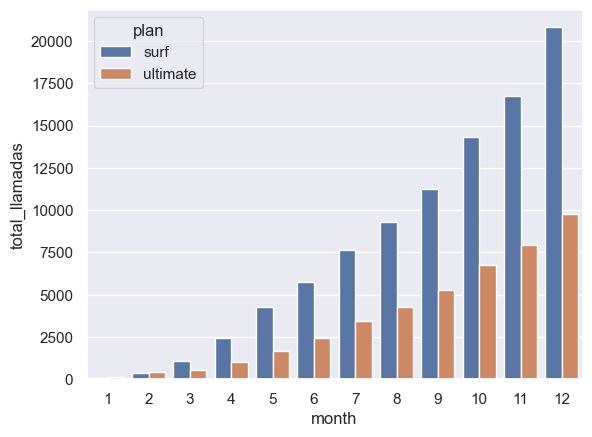

In [57]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
graf1 = bigtable.groupby(["month","plan"])["total_llamadas"].sum().reset_index()

sns.barplot(data= graf1, x= "month", y= "total_llamadas", hue= "plan")
plt.show()

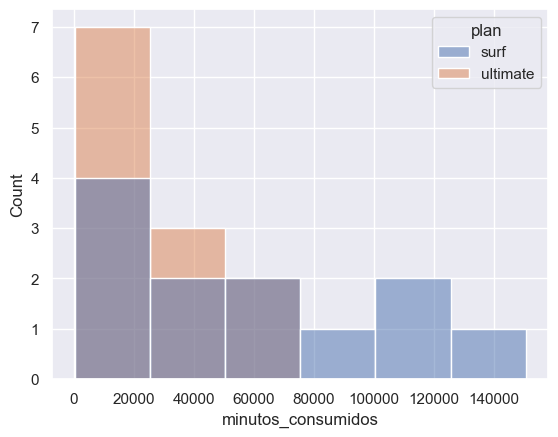

In [58]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
#bigtable["minutos_consumidos"].plot(kind="hist")

graf2= bigtable.groupby(["month","plan"])["minutos_consumidos"].sum().reset_index()
sns.histplot(data= graf2, x= "minutos_consumidos", hue= "plan")
plt.show()

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [59]:
# Calcula la media y la varianza de la duración mensual de llamadas.
bigtable.groupby("month")["minutos_consumidos"].describe()


,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,6.0,196.666667,114.611809,16.0,130.75,234.0,289.25,292.0
2,16.0,343.437500,248.127647,0.0,205.50,286.5,462.00,811.0
3,35.0,321.171429,208.275056,23.0,148.00,307.0,430.50,788.0
4,71.0,347.197183,213.589635,16.0,189.50,321.0,490.50,1043.0
5,106.0,401.405660,234.415251,0.0,241.25,410.0,559.50,1055.0
6,144.0,411.604167,212.335209,0.0,258.25,411.0,533.75,1033.0
7,180.0,442.472222,254.019254,0.0,296.75,438.0,579.50,1188.0
8,233.0,413.562232,232.221332,0.0,257.00,395.0,548.00,1292.0
9,280.0,421.378571,223.015468,0.0,256.50,430.0,551.25,1232.0


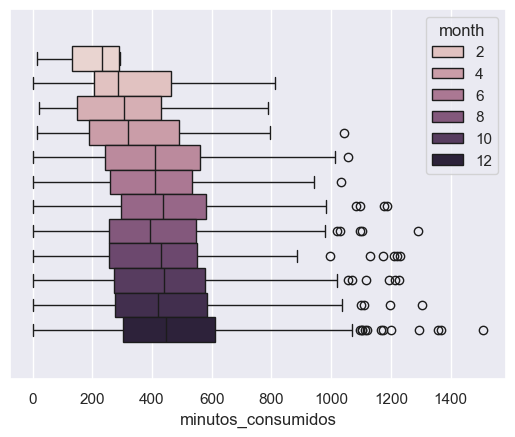

      minutos_consumidos  month      plan
0                  124.0     12  ultimate
1                  182.0      8      surf
2                  315.0      9      surf
3                  393.0     10      surf
4                  426.0     11      surf
...                  ...    ...       ...
2288               339.0     12      surf
2289               346.0      9      surf
2290               385.0     10      surf
2291               308.0     11      surf
2292               496.0     12      surf

[2293 rows x 3 columns]


In [82]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

#bigtable.groupby("month")["total_llamadas"].sum().plot(kind="box")

graf5= bigtable[["minutos_consumidos","month","plan"]]
sns.boxplot(data= graf5, x= "minutos_consumidos",hue="month")
plt.show()

print(graf5)


[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a las llamadas. ¿Su comportamiento varía en función del plan?]

Se observa que los usuarios de surf consumen mas que los usuarios ultimate aparentemente

### Mensajes

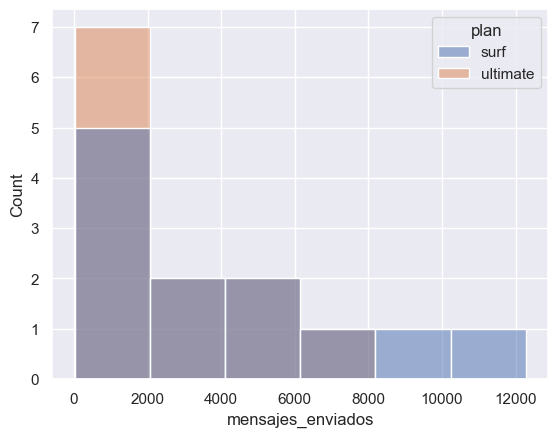

In [61]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
graf3= bigtable.groupby(["month","plan"])["mensajes_enviados"].sum().reset_index()
sns.histplot(data= graf3, x= "mensajes_enviados", hue= "plan")
plt.show()

[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes. ¿Su comportamiento varía en función del plan?]


Se observa que los usuarios de surf consumen mas que los usuarios ultimate aparentemente



### Internet

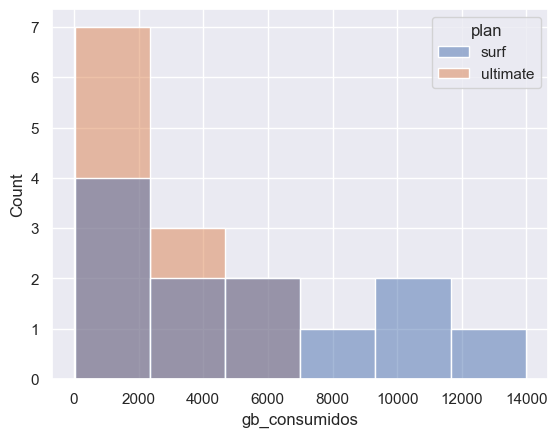

In [62]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

graf4= bigtable.groupby(["month","plan"])["gb_consumidos"].sum().reset_index()
sns.histplot(data= graf4, x= "gb_consumidos", hue= "plan")
plt.show()

[Elabora las conclusiones sobre cómo los usuarios tienden a consumir el tráfico de Internet. ¿Su comportamiento varía en función del plan?]

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

In [63]:
bigtable ["cobro_total"] = bigtable ["mensajes_cobro_Excedente"] +bigtable ["llamadas_cobro_Excedente"] +bigtable ["internet_cobro_Excedente"] + bigtable ["usd_monthly_pay"] 
bigtable.pivot_table(index="plan",values=["mensajes_cobro_Excedente","llamadas_cobro_Excedente","internet_cobro_Excedente","cobro_total"], aggfunc= ["mean","std"])

mean                                                    \
         cobro_total internet_cobro_Excedente llamadas_cobro_Excedente   
plan                                                                     
surf      282.117724               260.063573                  1.84377   
ultimate  166.629167                96.629167                  0.00000   

                                          std                           \
         mensajes_cobro_Excedente cobro_total internet_cobro_Excedente   
plan                                                                     
surf                     0.210381  163.239312               162.708456   
ultimate                 0.000000   87.318976                87.318976   

                                                            
         llamadas_cobro_Excedente mensajes_cobro_Excedente  
plan                                                        
surf                     3.765744                 0.584127  
ultimate                 0.000000                 0.000000

In [64]:
#Estos resultados en conjunto nos señalan que los usuarios Surf consumen mas que los usuarios de ultimate.

[Elabora las conclusiones sobre cómo difiere el ingreso entre los planes.]

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [65]:
# Prueba las hipótesis
#bigtable.query("plan == 'ultimate'")["cobro_total"]

alpha = 0.05
results = st.ttest_ind(bigtable.query("plan == 'ultimate'")["cobro_total"], bigtable.query("plan == 'surf'")["cobro_total"])


In [66]:
print('valor p:', results.pvalue) # tu código: imprime el valor p obtenido)
print()
if results.pvalue < alpha:# su código: compara los valores p obtenidos con el nivel de significación estadística):
    print("Rechazamos la hipótesis nula, los usuarios Surf consumen más")
else:
    print("No podemos rechazar la hipótesis nula, los usuarios surf NO consumen más")

valor p: 7.954135633537011e-67

Rechazamos la hipótesis nula, los usuarios Surf consumen más


[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [67]:
# Prueba las hipótesis
ny_nj = bigtable[bigtable["city"].str.contains("NY-NJ")]["cobro_total"]
non_ny_nj = bigtable[~bigtable["city"].str.contains("NY-NJ")]["cobro_total"]
results2 = st.ttest_ind(ny_nj, non_ny_nj)

In [68]:
print('valor p:', results.pvalue) # tu código: imprime el valor p obtenido)
print()
if results2.pvalue < alpha:# su código: compara los valores p obtenidos con el nivel de significación estadística):
    print("Rechazamos la hipótesis nula, los usuarios NY-NJ consumen más")
else:
    print("No podemos rechazar la hipótesis nula, los usuarios NY-NJ NO consumen más")

valor p: 7.954135633537011e-67

Rechazamos la hipótesis nula, los usuarios NY-NJ consumen más


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]